In [1]:
from private.db.tianrun.spot.fdw.new_energy_actual_power import market_hourly_actual_power, market_name_dict
from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import ProvinceForecastData

from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla import VanillaTransformer, vanilla_transformer_tester, vanilla_transformer_trainer
import numpy
import pickle
from easy_datetime.timestamp import TimeStamp

import torch
from matplotlib import pyplot as plt
from data_utils.serial_utils.series_trans_utils import MinMax, ZScore, RobustScaler, KmeansCluster

import os

In [4]:
root = r"E:\code\github\private\private\db\tencnet\openmeteo\data"

pfd = ProvinceForecastData("shanxi", "2024-10-1", "2024-10-31")
if os.path.exists(f"{root}\\test4.pfd"):
    pass
else:
    pfd.add_new_energy_forecast("ecmwf")
    pfd.save(f"{root}\\test4.pfd")


with open(f"{root}\\test4.pfd", "rb") as f:
    pfd:ProvinceForecastData = pickle.loads(f.read())
    
print(pfd.stdt)
print(pfd.eddt)

2024-10-01 00:00:00
2024-10-31 23:59:59


In [47]:
fore_start = TimeStamp("2024-10-1")
fore_days = 20
fore_end = fore_start + ["day", fore_days]
print(fore_start)
print(fore_end)

forecast_date = TimeStamp.timestamp_range(fore_start, fore_end,"day",1,True)
data = pfd["ecmwf","evening",1,1, forecast_date]
actual = market_hourly_actual_power(
    market_name_dict["shanxi"], fore_start.get_date_string(), (fore_end - ["day", 1]).get_date_string()
)["power"]
x = torch.Tensor(numpy.apply_along_axis(ZScore.n, axis=0, arr=data)[:fore_days*24])
y = torch.Tensor(numpy.apply_along_axis(ZScore.n, axis=0, arr=actual))
print(x.shape)
print(y.shape)

actual_hat = market_hourly_actual_power(
    market_name_dict["shanxi"], fore_start.get_date_string(), (fore_end).get_date_string()
)["power"]
x_hat = torch.Tensor(numpy.apply_along_axis(ZScore.n, axis=0, arr=data))
y_hat = torch.Tensor(numpy.apply_along_axis(ZScore.n, axis=0, arr=actual_hat))

print(x_hat.shape)
print(y_hat.shape)

2024-10-01 00:00:00
2024-10-21 00:00:00
torch.Size([480, 582])
torch.Size([480])
torch.Size([504, 582])
torch.Size([504])


In [48]:
input_size = data.shape[1]
d_model = 512
dim_feedforward = d_model * 4
nhead = 8
output_size = 1
num_layers = 4
batch_size = 6
lr = 1e-5
model = VanillaTransformer(
    input_size=input_size,
    output_size=output_size,
    num_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)
print(model.cuda_device)

cuda


In [49]:
trained_model = vanilla_transformer_trainer(model, x, y, batch_size, 100, lr=lr)

100%|██████████| 100/100 [00:05<00:00, 18.08it/s]


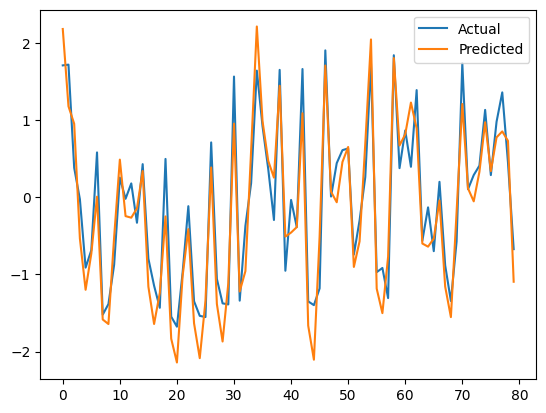

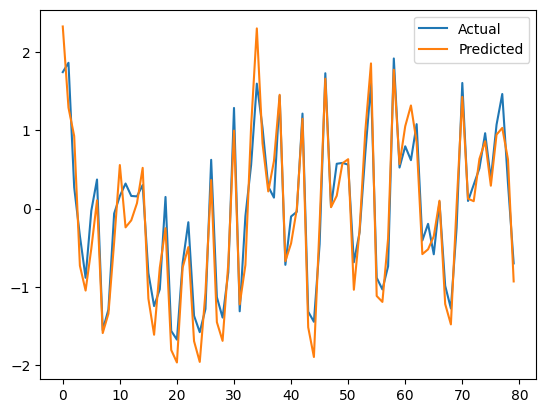

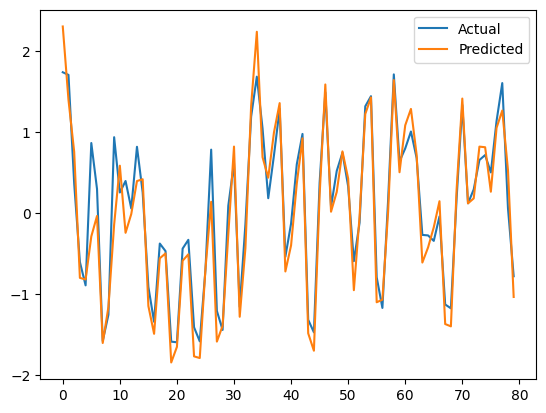

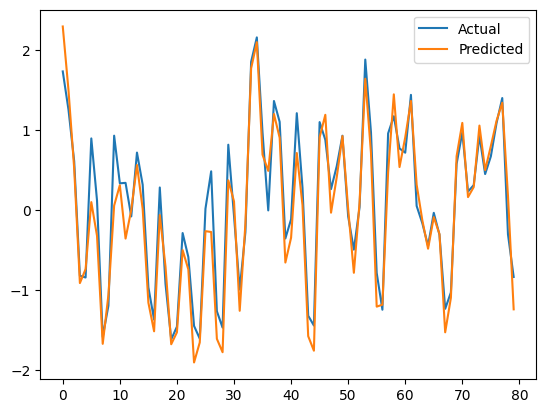

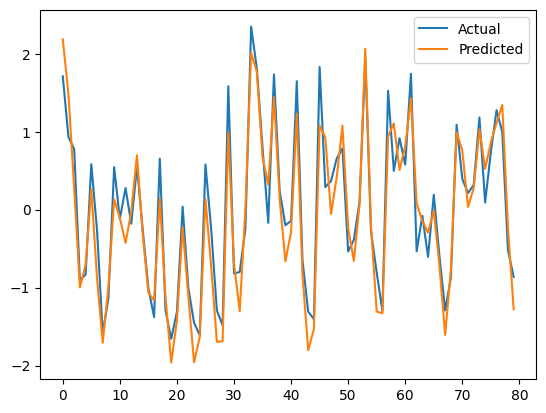

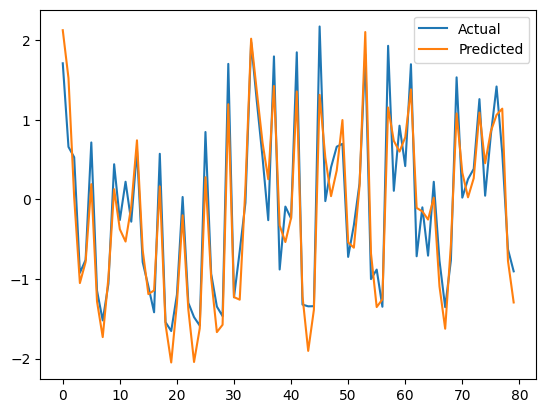

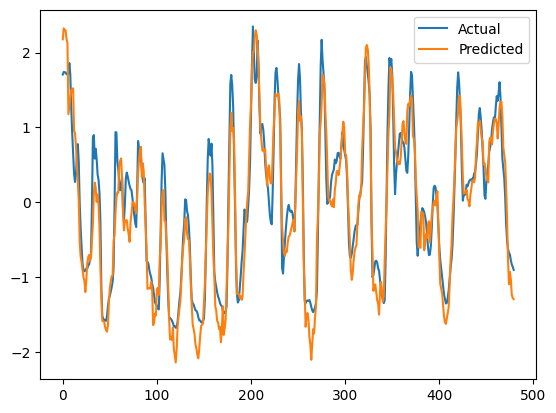

In [50]:
p_train = vanilla_transformer_tester(trained_model, x, batch_size)
for _ in range(batch_size):
    plt.plot(y.reshape(-1,batch_size,1)[:,_], label='Actual')
    plt.plot(p_train.cpu()[:,_], label='Predicted')
    plt.legend()
    plt.show()
    
plt.plot(y.reshape(-1), label='Actual')
plt.plot(p_train.cpu().reshape(-1), label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

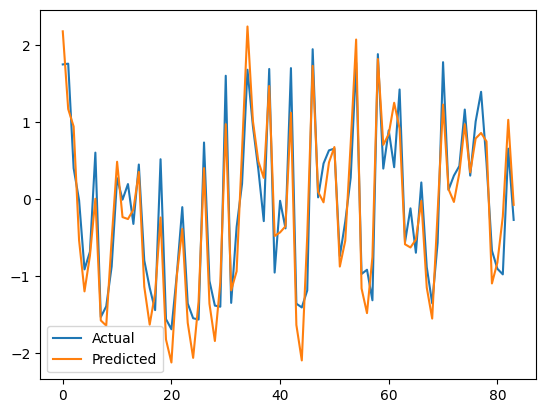

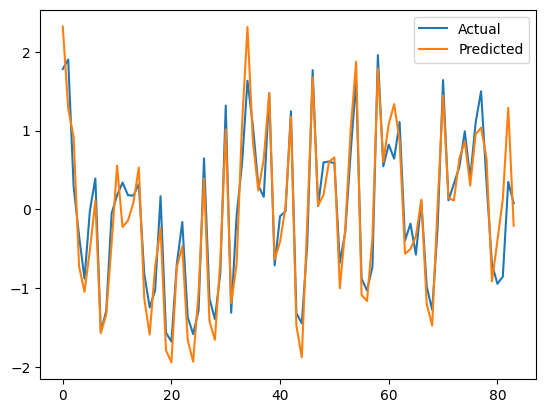

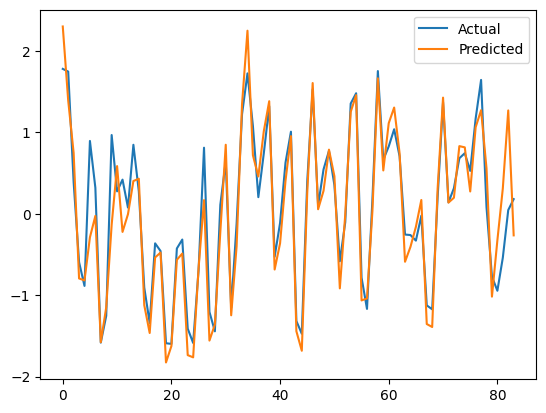

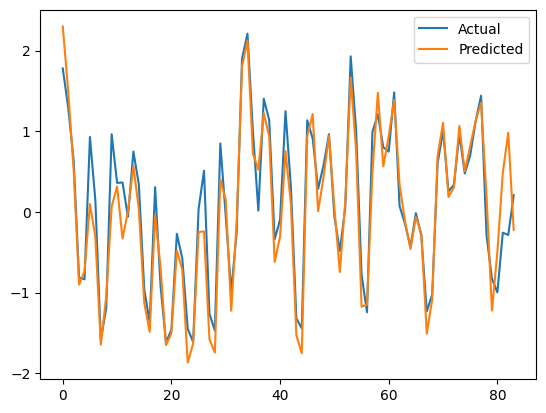

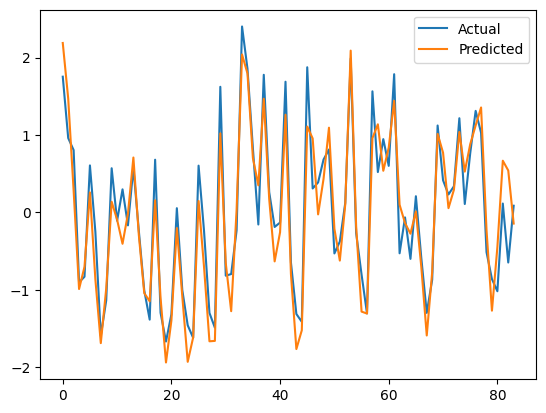

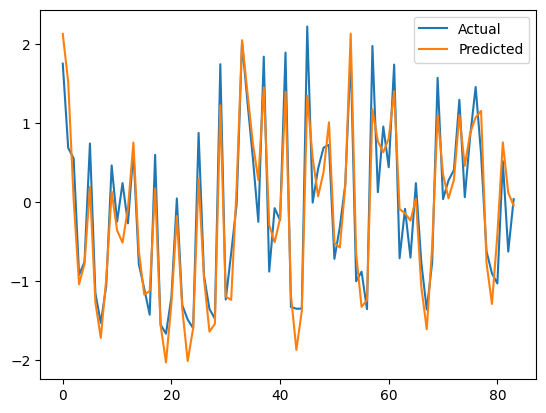

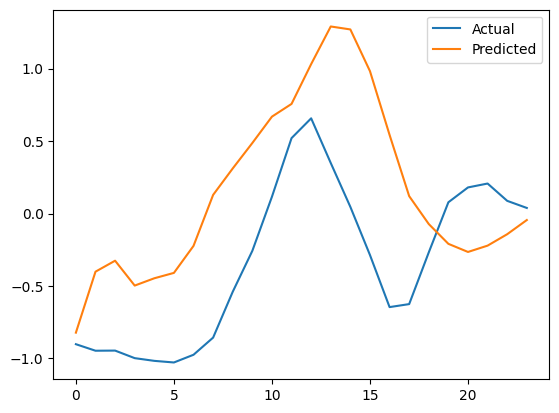

In [51]:
p_train = vanilla_transformer_tester(trained_model, x_hat, batch_size)
for _ in range(batch_size):
    plt.plot(y_hat.reshape(-1,batch_size,1)[:,_], label='Actual')
    plt.plot(p_train.cpu()[:,_], label='Predicted')
    plt.legend()
    plt.show()
    
plt.plot(y_hat.reshape(-1)[fore_days*24:], label='Actual')
plt.plot(p_train.cpu().reshape(-1)[fore_days*24:], label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()